In [0]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, concatenate, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [0]:
token = 'Flickr8k_text/Flickr8k.token.txt'
captions = open(token, 'r').read().strip().split('\n')


In [0]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]


In [0]:

d['1000268201_693b08cb0e.jpg']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [0]:
# Contains all the images
img = glob.glob(images+'*.jpg')


In [0]:
img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset/2882893687_1d10d68f2b.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2933637854_984614e18b.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2273591668_069dcb4641.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/162152393_52ecd33fc5.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/662606040_8cc8cd9f1b.jpg']

In [0]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [0]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [0]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [0]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [0]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [0]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [0]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))


In [0]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

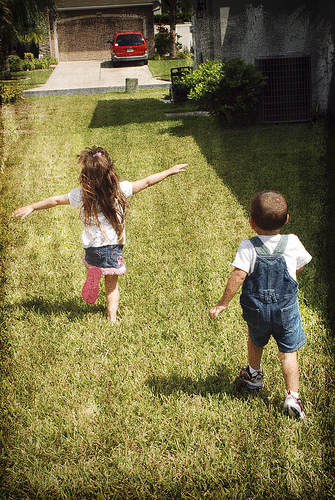

In [0]:
Image.open(train_img[0])

In [0]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


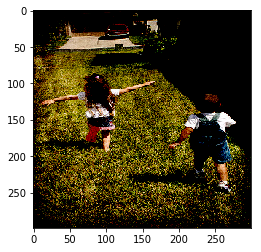

In [0]:


plt.imshow(np.squeeze(preprocess(train_img[0])))


In [0]:
np.shape(np.squeeze(preprocess(train_img[0])))

(299, 299, 3)

In [0]:
model = InceptionV3(weights='imagenet')

In [0]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [0]:
tryi = model_new.predict(preprocess(train_img[0]))
tryi.shape

(1, 2048)

In [0]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [0]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

  6%|▌         | 369/6000 [00:09<02:32, 36.91it/s]/home/viplab/anaconda3/envs/RobotArm/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 6000/6000 [02:34<00:00, 38.71it/s]


In [0]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [0]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [0]:
encoding_train['3556792157_d09d42bef7.jpg'].shape


(2048,)

In [0]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [00:25<00:00, 38.85it/s]


In [0]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [0]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [0]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [0]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]


In [0]:
len(train_d)

6000

In [0]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [0]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [0]:
len(val_d)

1000

In [0]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [0]:
len(test_d)

1000

In [0]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [0]:
words = [i.split() for i in caps]

In [0]:
unique = []
for i in words:
    unique.extend(i)

In [0]:
unique = list(set(unique))

In [0]:
unique = pickle.load(open('unique.p', 'rb'))

In [0]:
len(unique)

8256

In [0]:
word2idx = {val:index for index, val in enumerate(unique)}

In [0]:
word2idx['<start>']

5553

In [0]:
idx2word = {index:val for index, val in enumerate(unique)}

In [0]:
idx2word[5553]

'<start>'

In [0]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [0]:
len(unique), max_len

(8256, 40)

In [0]:
vocab_size = len(unique)

In [0]:
vocab_size

8256

In [0]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [0]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [0]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [0]:
len(df)

30000

In [0]:
c = [i for i in df['captions']]
len(c)

30000

In [0]:
imgs = [i for i in df['image_id']]

In [0]:
a = c[-1]
a, imgs[-1]


('<start> Fluffy white dog running on pebbles along the shore . <end>',
 '2288315705_5f4c37d932.jpg')

In [0]:


for i in a.split():
    print (i, "=>", word2idx[i])



<start> => 5553
Fluffy => 49
white => 2970
dog => 173
running => 6030
on => 803
pebbles => 6772
along => 4438
the => 7392
shore => 8209
. => 7023
<end> => 5232


In [0]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [0]:
samples_per_epoch

383454

In [0]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [0]:
embedding_size = 300

In [0]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [0]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [0]:
concat_layers=concatenate([image_model.output, caption_model.output])
layer=Bidirectional(LSTM(256, return_sequences=False))(concat_layers)
layer=Dense(vocab_size)(layer)
outlayer=Activation('softmax')(layer)
final_model = Model([image_model.input,caption_model.input],[outlayer])



In [0]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [0]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      2476800     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      dense_1_input[0][0]              
__________________________________________________________________________________________________
lstm_1 (LS

In [0]:


final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)



Epoch 1/1
2996/2995 [==============================] - 294s 98ms/step - loss: 3.3599 - acc: 0.4415


In [0]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)

Epoch 1/1
2996/2995 [==============================] - 285s 95ms/step - loss: 3.2604 - acc: 0.4506


In [0]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)

Epoch 1/1
2996/2995 [==============================] - 295s 98ms/step - loss: 3.2131 - acc: 0.4558


In [0]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)

Epoch 1/1
2996/2995 [==============================] - 285s 95ms/step - loss: 3.2135 - acc: 0.4561


In [0]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)

Epoch 1/1
2996/2995 [==============================] - 285s 95ms/step - loss: 3.2059 - acc: 0.4585


In [0]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)

Epoch 1/1
2996/2995 [==============================] - 296s 99ms/step - loss: 3.2038 - acc: 0.4604


In [0]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)

Epoch 1/1
2996/2995 [==============================] - 286s 95ms/step - loss: 3.2343 - acc: 0.4598


In [0]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)

Epoch 1/1
2996/2995 [==============================] - 286s 96ms/step - loss: 3.2260 - acc: 0.4595


In [0]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)

Epoch 1/1
2996/2995 [==============================] - 286s 95ms/step - loss: 3.2256 - acc: 0.4608


In [0]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128,verbose=1)

Epoch 1/1
2996/2995 [==============================] - 286s 95ms/step - loss: 3.2204 - acc: 0.4597


In [0]:


final_model.save_weights('vip_net.h5')



In [0]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [0]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

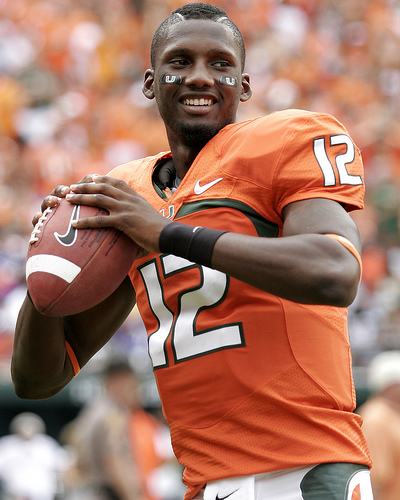

In [0]:
try_image = test_img[0]
Image.open(try_image)

In [0]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A group of men and women are playing baseball .
Beam Search, k=3: A group of men play in the water .
Beam Search, k=5: A group of men playing football .
Beam Search, k=7: A group of men playing football .


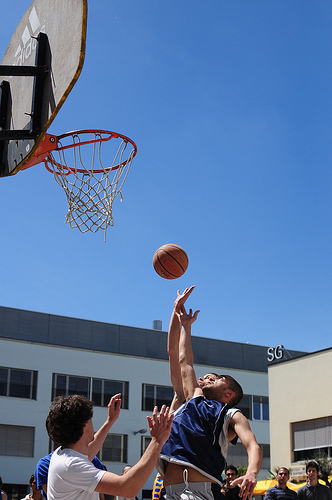

In [0]:
try_image2 = test_img[7]
Image.open(try_image2)

In [0]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A young man in a red shirt is jumping into a white ball .
Beam Search, k=3: A young man in a red shirt is jumping into a white ball .
Beam Search, k=5: A group of men on a field .
Beam Search, k=7: A group of men on a field .


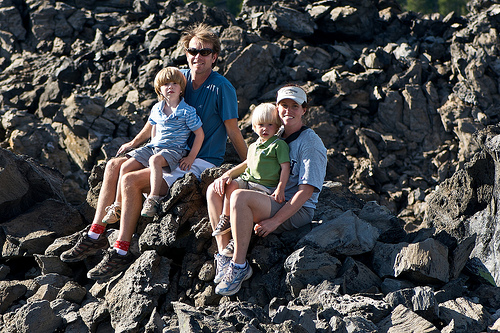

In [0]:
try_image3 = test_img[851]
Image.open(try_image3)

In [0]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: A man in a blue shirt is standing in the snow .
Beam Search, k=3: A group of people are standing near a wall .
Beam Search, k=5: A group of people in the snow .
Beam Search, k=7: There is a group of people sitting at the top of a mountain .


Normal Max search: A bmx closed .
Beam Search, k=3: A bmx closed .
Beam Search, k=5: A bmx bmx in midair .
Beam Search, k=7: A bmx bmx in midair .


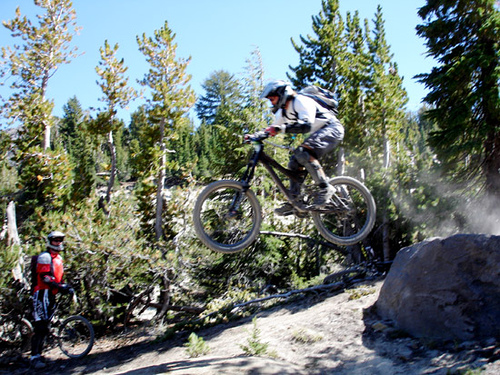

In [0]:
try_image4 = 'Flickr8k_Dataset/Flicker8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

Normal Max search: A white dog is running on some grass .
Beam Search, k=3: A white dog is running through the snow .
Beam Search, k=5: A white dog is running on an obstacle course .
Beam Search, k=7: A white dog is running on an obstacle course .


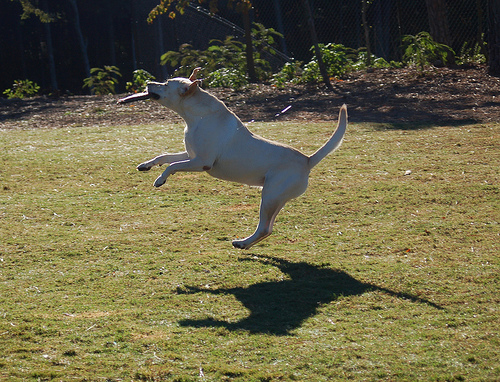

In [0]:


im = 'Flickr8k_Dataset/Flicker8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)



Normal Max search: A man wearing black and white is looking of some skater in climbing .
Beam Search, k=3: A man wearing a white jacket is riding a white white race dog in a forest .
Beam Search, k=5: A white dog wearing a red jacket is looking through the snow .
Beam Search, k=7: A white dog wearing a red jacket rides a snow in the snow .


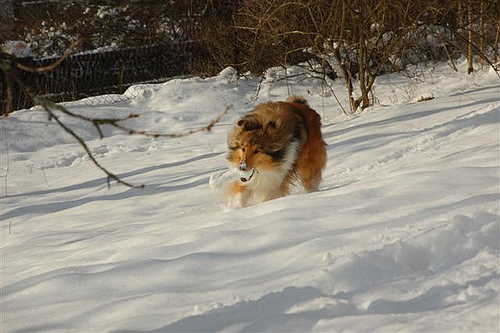

In [0]:


im = 'Flickr8k_Dataset/Flicker8k_Dataset/384577800_fc325af410.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

